In [1]:
prompt = "A painting of the Great Wave off Kanagawa by Katsushika Hokusai"
num_inference_steps = 50
guidance_scale = 7.5
num_images_per_prompt = 4
image_size = 512
seed = 42

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
from diffusers import DDIMScheduler
import json

try:
    from local_sd_pipeline import LocalStableDiffusionPipeline
    from optim_utils import *
except ModuleNotFoundError:
    import os; os.chdir("..")
    from local_sd_pipeline import LocalStableDiffusionPipeline
    from optim_utils import *


with open('match_verbatim_captions.json') as f:
    all_mem_captions = json.load(f)
    
%load_ext autoreload
%autoreload 2

/home/hamid/miniforge3/envs/geometric_diffusion_memorization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load model
torch.cuda.set_device(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_id = "CompVis/stable-diffusion-v1-4"

pipe = LocalStableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False,
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

/home/hamid/miniforge3/envs/geometric_diffusion_memorization/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 11.58it/s]


## Original Generation


100%|██████████| 50/50 [00:03<00:00, 12.67it/s]


prompt: A painting of the Great Wave off Kanagawa by Katsushika Hokusai


,,,

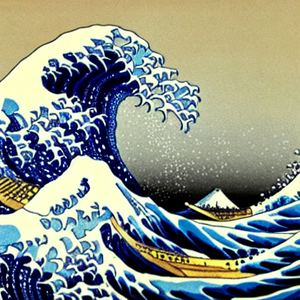
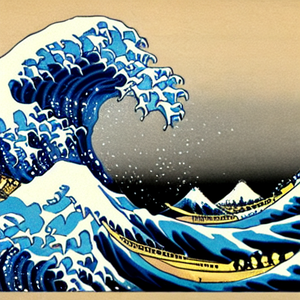
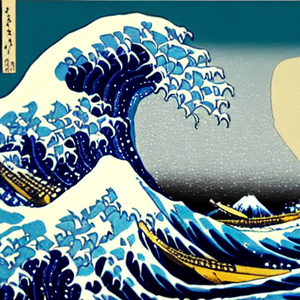
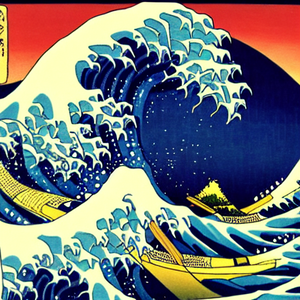

In [4]:
set_random_seed(seed)

outputs, track_stats = pipe(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=num_images_per_prompt,
    track_noise_norm=True,
)
outputs = outputs.images

print(f"prompt: {prompt}")
media.show_images(outputs, width=300)

## Getting Significance Score


 98%|█████████▊| 49/50 [00:35<00:00,  1.38it/s]


prompt:A painting of the Great Wave off Kanagawa by Katsushika Hokusai


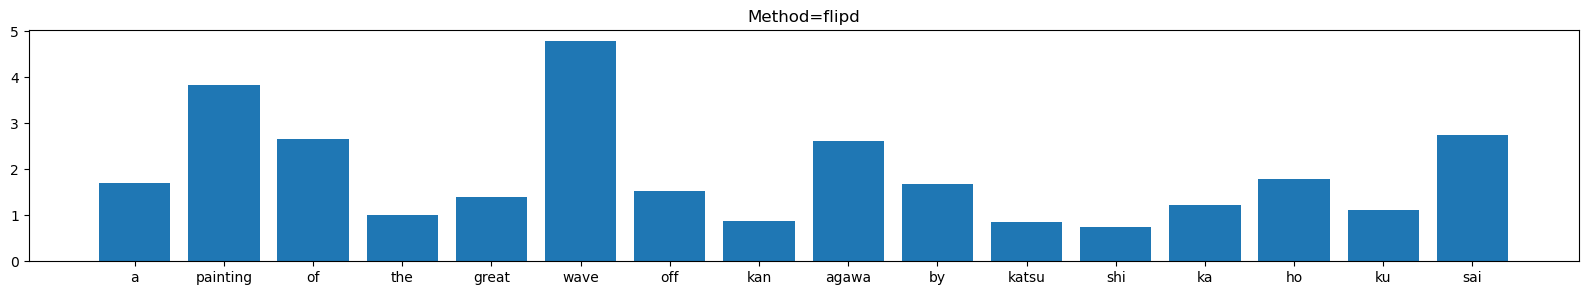

In [15]:
# get token-wise grad norm
%matplotlib inline
set_random_seed(seed)
method = "flipd"
token_grads = pipe.get_text_cond_grad(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=1 if method == "flipd" else num_images_per_prompt,
    target_steps=list(range(50)),
    method=method,
)
torch.cuda.empty_cache()

prompt_tokens = pipe.tokenizer.encode(prompt)
prompt_tokens = prompt_tokens[1:-1]
prompt_tokens = prompt_tokens[:75]
token_grads = token_grads[1:(1+len(prompt_tokens))]
token_grads = token_grads.cpu().tolist()

all_tokes = []

for curr_token in prompt_tokens:
    all_tokes.append(pipe.tokenizer.decode(curr_token))

print(f"prompt:{prompt}")
plt.figure(figsize=(20, 3))
plt.bar(all_tokes, token_grads)
plt.title(f"Method={method}")
plt.show()

## Modify the Prompt According to the Significance Score


In [17]:
from perturb_gpt import perturb_prompt
prompt_modified, selected_tokens = perturb_prompt(
    prompt_tokens=all_tokes,
    tokens_and_attributes=[[tok, grad] for tok, grad in zip(all_tokes, token_grads)],
    level=3,
    temperature=0.01,
)
print(f"The modified prompt is:\n\t{prompt_modified}")
print(f"The selected tokens are:\n\t{', '.join(selected_tokens)}")

The modified prompt is:
	a portrayal of the grand swell off kan agawa by katsu shi ka ho ku sai
The selected tokens are:
	wave, painting, sai


100%|██████████| 50/50 [00:03<00:00, 12.65it/s]


prompt modified: a portrayal of the grand swell off kan agawa by katsu shi ka ho ku sai


,,,

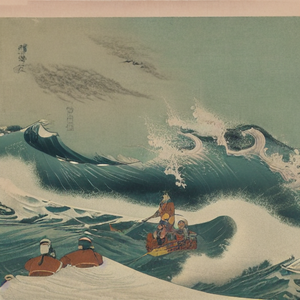
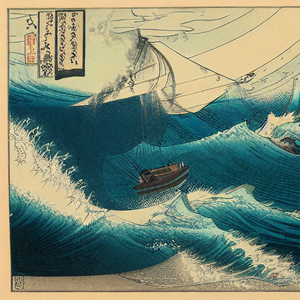
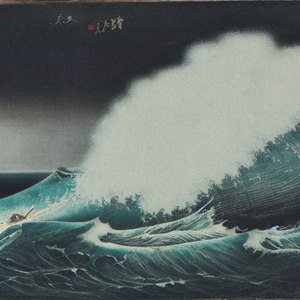
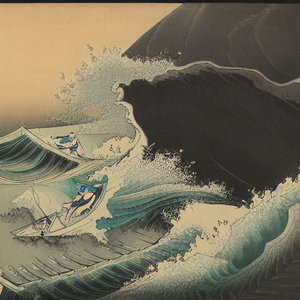

In [18]:
set_random_seed(seed)

outputs, track_stats = pipe(
    prompt_modified,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=num_images_per_prompt,
    track_noise_norm=True,
)
outputs = outputs.images

print(f"prompt modified: {prompt_modified}")
media.show_images(outputs, width=300)